# Credit Card Fraud Detection

Note that this dataset has already been transformed using PCA to preserve confidentiality.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/raw/creditcard.csv')

print(df.shape)
print(df.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


The df has already been transformed via PCA, so let's look at the remaining variables of interest.

# EDA

## df Understanding

In [2]:
missing = df.isnull().sum().sum()
print(f"Total missing values: {missing}")

Total missing values: 0


In [3]:
print(df[["Time","Amount","Class"]].info())
print()
print(df[["Time","Amount","Class"]].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   Amount  284807 non-null  float64
 2   Class   284807 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 6.5 MB
None

                Time         Amount          Class
count  284807.000000  284807.000000  284807.000000
mean    94813.859575      88.349619       0.001727
std     47488.145955     250.120109       0.041527
min         0.000000       0.000000       0.000000
25%     54201.500000       5.600000       0.000000
50%     84692.000000      22.000000       0.000000
75%    139320.500000      77.165000       0.000000
max    172792.000000   25691.160000       1.000000


## Class Distribution

In [4]:
print(df['Class'].value_counts())
print()
print(df['Class'].value_counts(normalize=True))

Class
0    284315
1       492
Name: count, dtype: int64

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


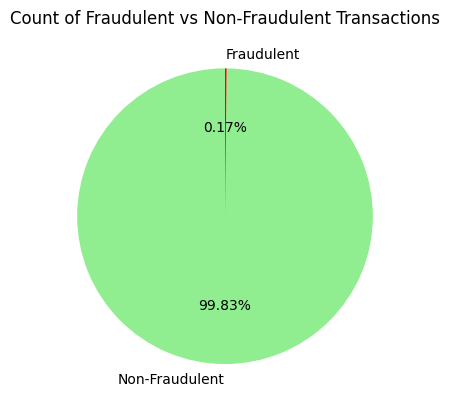

In [5]:
import matplotlib.pyplot as plt

fraud_ratio = df['Class'].value_counts(normalize=True)
fraud_ratio.plot(kind='pie', labels=['Non-Fraudulent', 'Fraudulent'], autopct='%1.2f%%', startangle=90, colors=['lightgreen', 'red'])
plt.title('Count of Fraudulent vs Non-Fraudulent Transactions')
plt.ylabel('')
plt.show()

## Amount Feature Exploration

As amount is one of the only non-PCA features, let's explore it in detail.

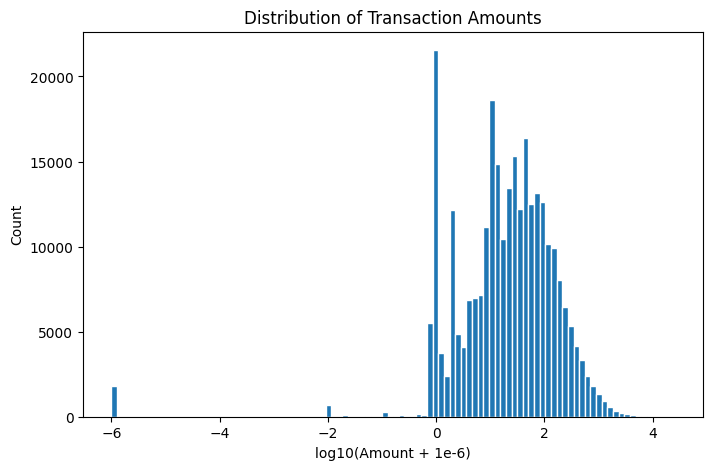

In [6]:
amount = df["Amount"].dropna()

plt.figure(figsize=(8, 5))
log_amount = np.log10(amount + 1e-6)
plt.hist(log_amount, bins=100, edgecolor="white")
plt.xlabel("log10(Amount + 1e-6)")
plt.ylabel("Count")
plt.title("Distribution of Transaction Amounts")
plt.show()

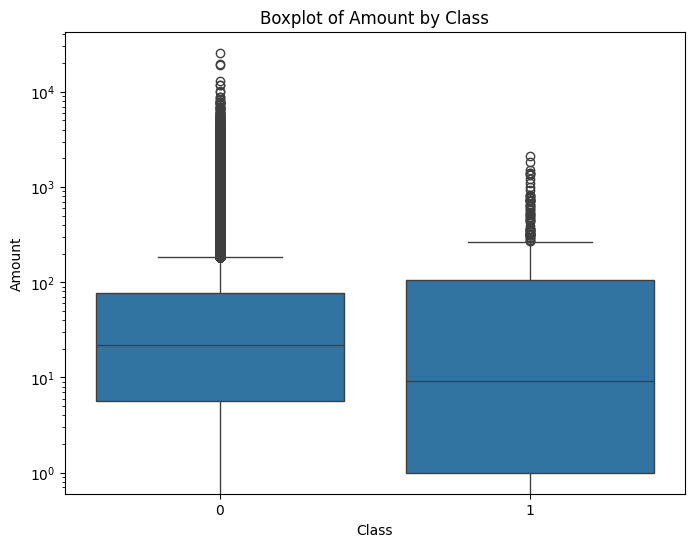

In [7]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Boxplot of Amount by Class')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.yscale('log')
plt.show()

In [8]:
stats = (
    df.groupby("Class")["Amount"]
      .agg(count="size", mean="mean", median="median", std="std", min="min", max="max")
      .round(2)
)
display(stats)

,count,mean,median,std,min,max
Class,,,,,,
0,284315,88.29,22.00,250.11,0.0,25691.16
1,492,122.21,9.25,256.68,0.0,2125.87


Top 1% threshold: 1017.97
Fraud rate (top 1%):  0.3159%
Fraud rate (rest 99%): 0.1713%


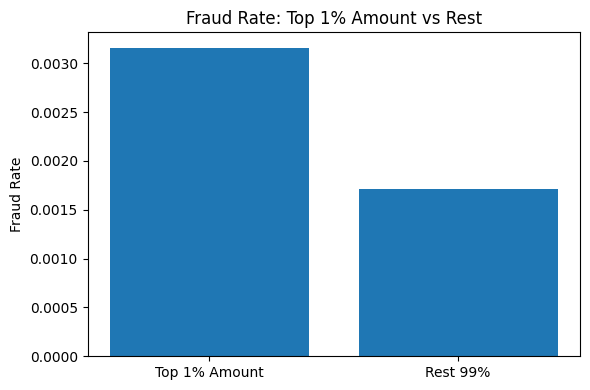

In [9]:
# Fraud rate in the top 1% by Amount

threshold = df["Amount"].quantile(0.99)
top_mask = df["Amount"] >= threshold

top_df = df.loc[top_mask]
rest_df = df.loc[~top_mask]

fraud_rate_top = top_df["Class"].mean()
fraud_rate_rest = rest_df["Class"].mean()

print(f"Top 1% threshold: {threshold:.2f}")
print(f"Fraud rate (top 1%):  {fraud_rate_top:.4%}")
print(f"Fraud rate (rest 99%): {fraud_rate_rest:.4%}")

# Simple bar chart to compare fraud rates
plt.figure(figsize=(6,4))
plt.bar(["Top 1% Amount", "Rest 99%"], [fraud_rate_top, fraud_rate_rest])
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate: Top 1% Amount vs Rest")
plt.tight_layout()
plt.show()

## Time Feature Exploration

In [10]:
time_df = df.copy()
time_df['Hour'] = ((time_df['Time'] // 3600) % 24).astype(int)

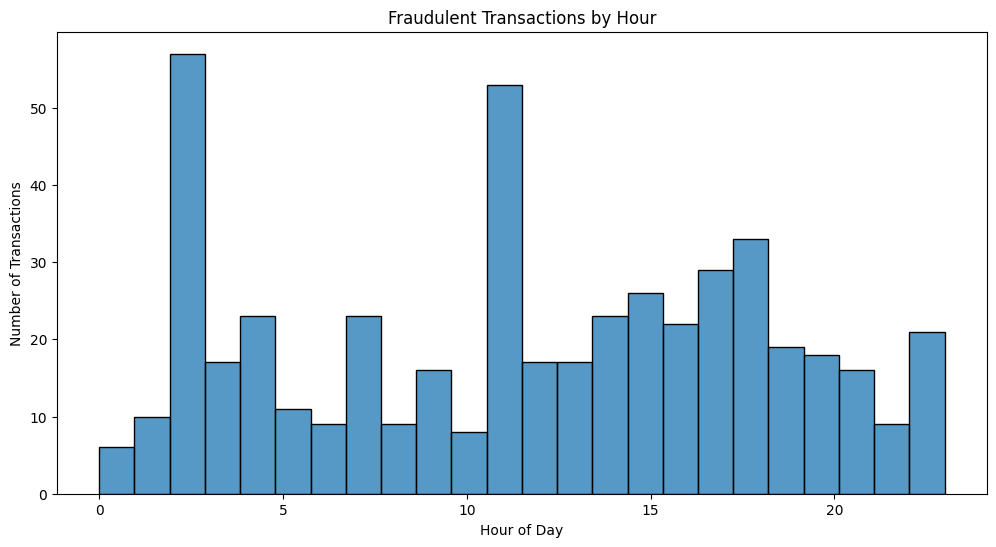

In [11]:
fraudulent_data = time_df[time_df["Class"] == 1]

plt.figure(figsize=(12,6))
sns.histplot(data=fraudulent_data, x='Hour', bins=24)
plt.title('Fraudulent Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.show()

In [12]:
# Group by hour and calculate fraud rate
fraud_rate_by_hour = (
    time_df.groupby('Hour')['Class']
      .mean()
      .reset_index(name='FraudRate')
)

print(fraud_rate_by_hour)

    Hour  FraudRate
0      0   0.000780
1      1   0.002370
2      2   0.017127
3      3   0.004868
4      4   0.010412
5      5   0.003679
6      6   0.002195
7      7   0.003175
8      8   0.000876
9      9   0.001010
10    10   0.000482
11    11   0.003144
12    12   0.001102
13    13   0.001106
14    14   0.001388
15    15   0.001579
16    16   0.001337
17    17   0.001794
18    18   0.001937
19    19   0.001214
20    20   0.001074
21    21   0.000904
22    22   0.000583
23    23   0.001920


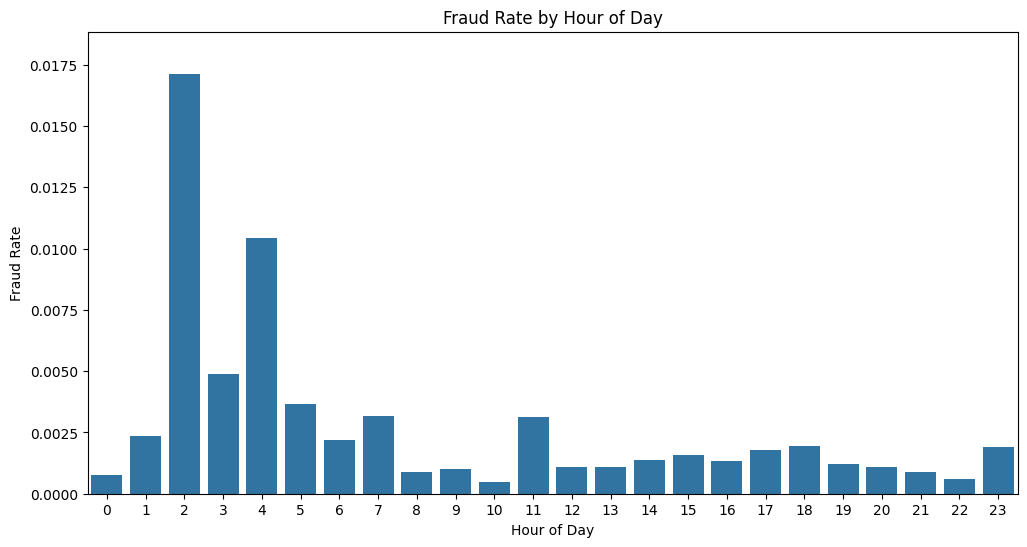

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_rate_by_hour, x='Hour', y='FraudRate')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.ylim(0, fraud_rate_by_hour['FraudRate'].max() * 1.1)
plt.show()

## PCA Components

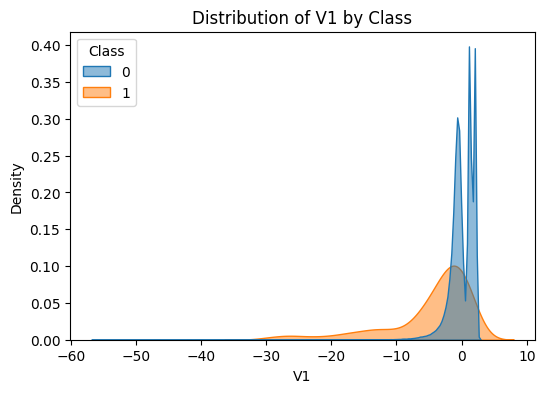

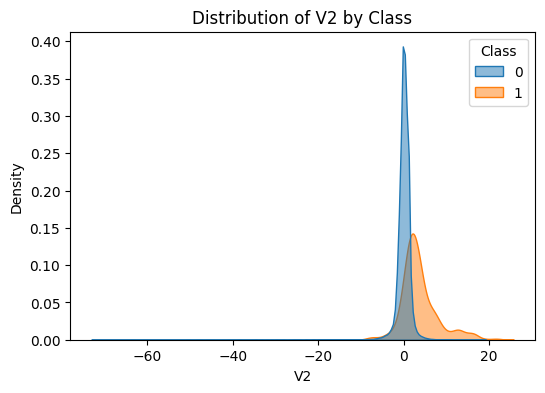

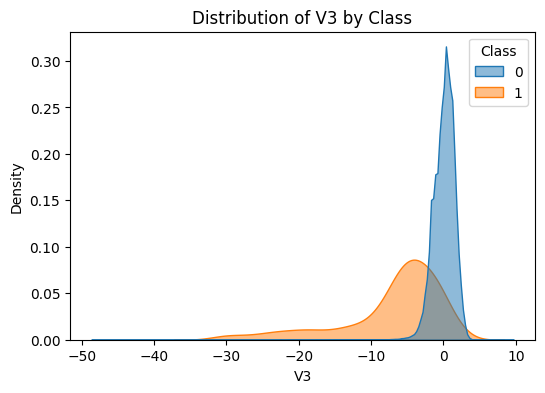

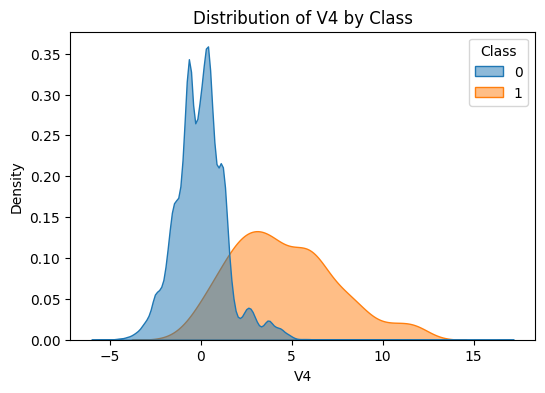

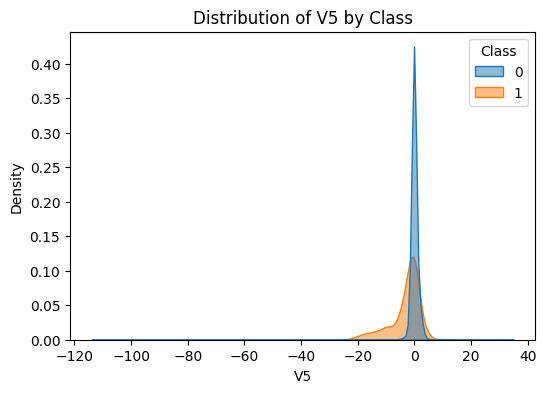

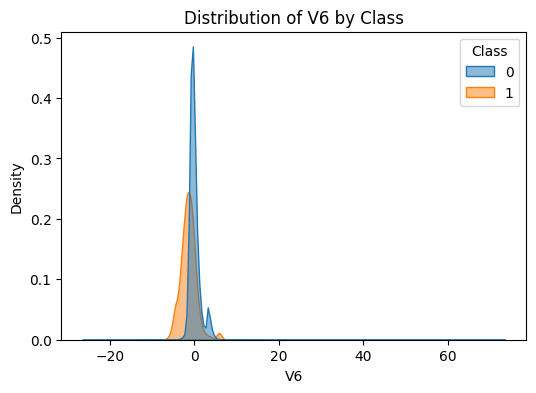

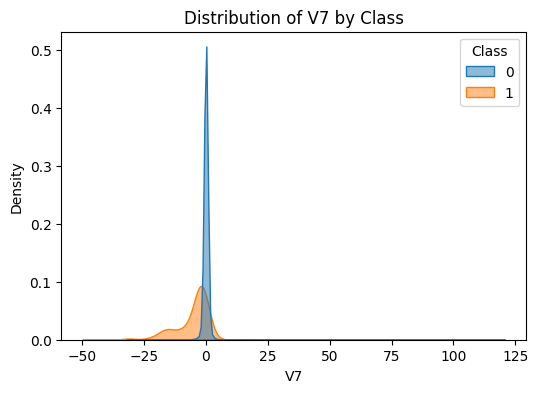

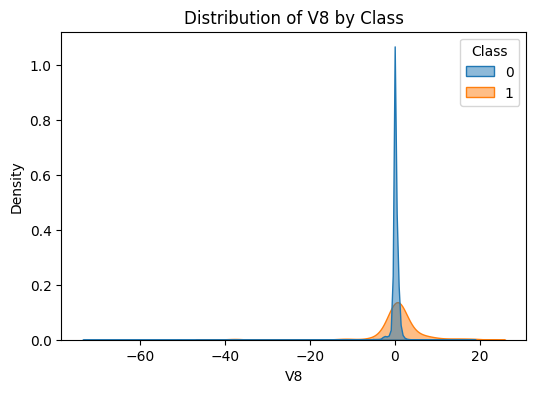

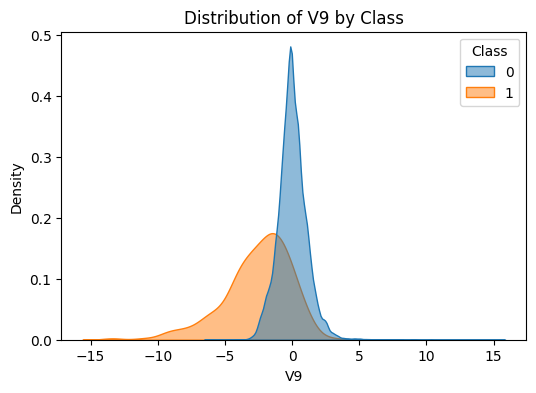

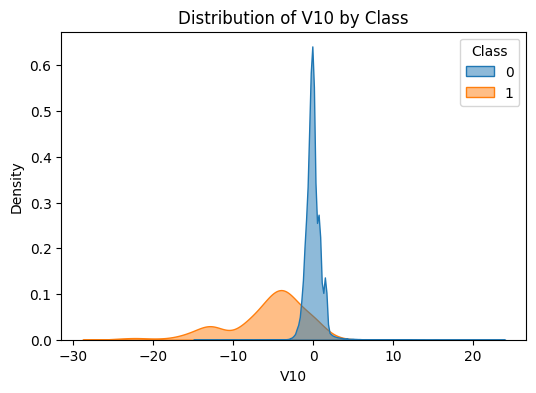

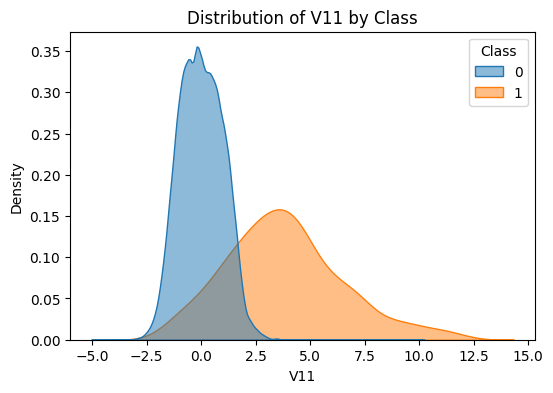

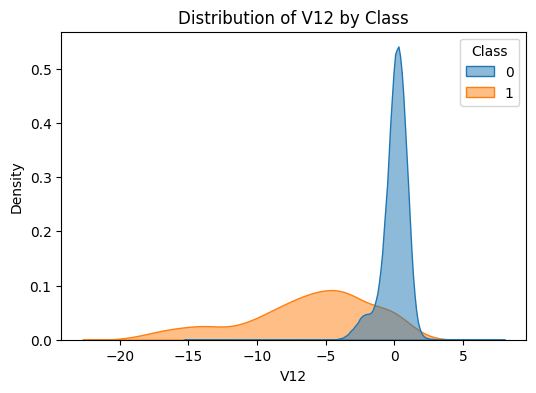

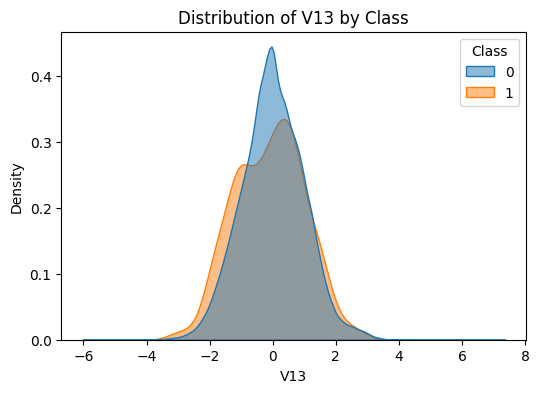

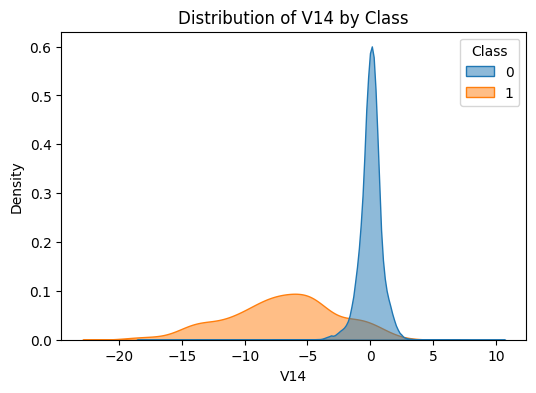

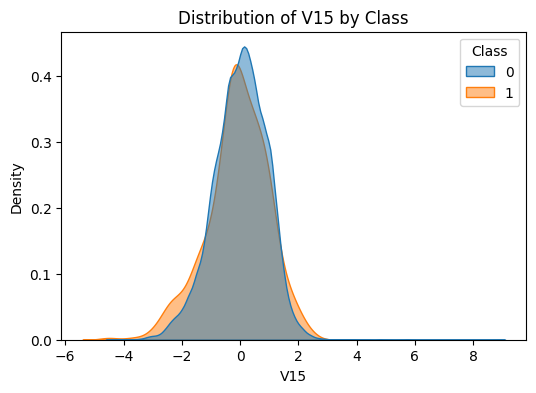

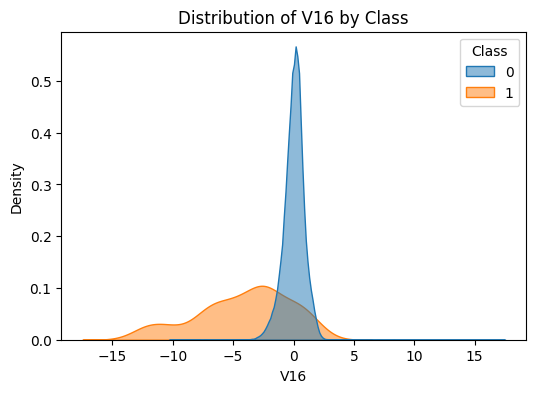

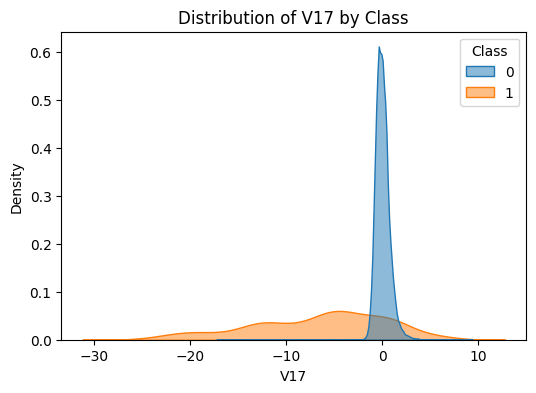

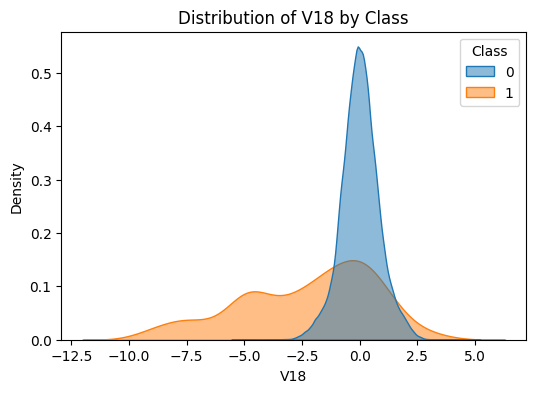

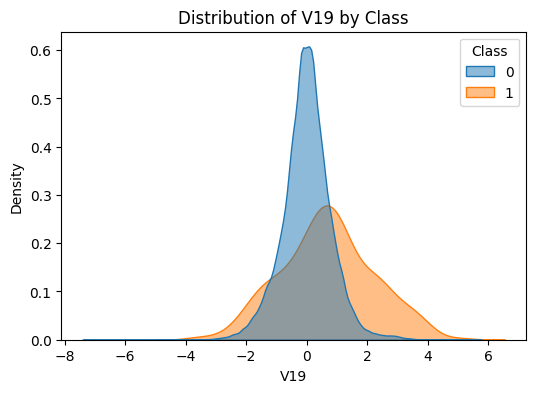

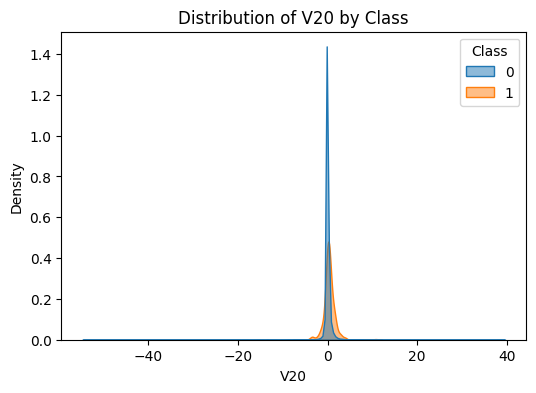

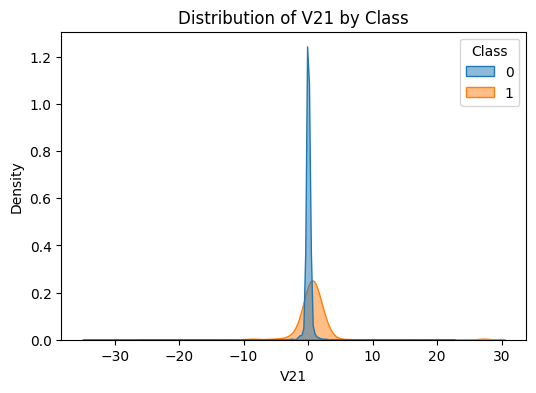

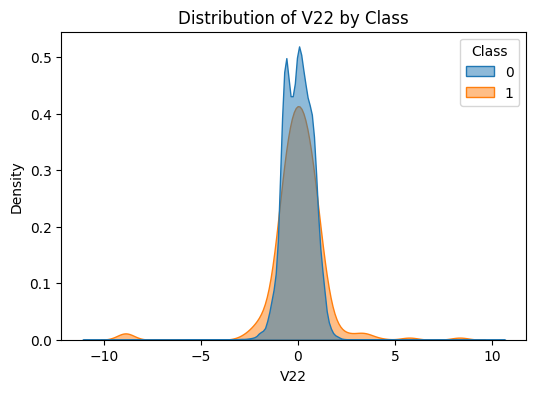

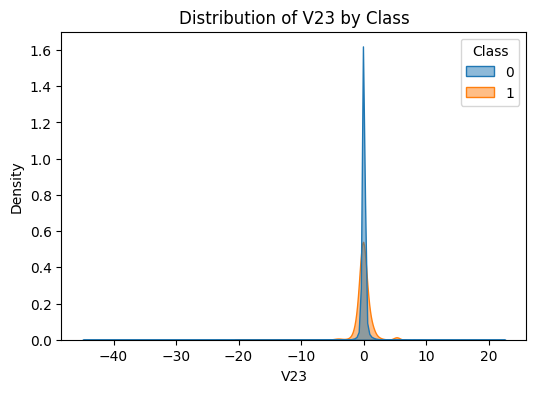

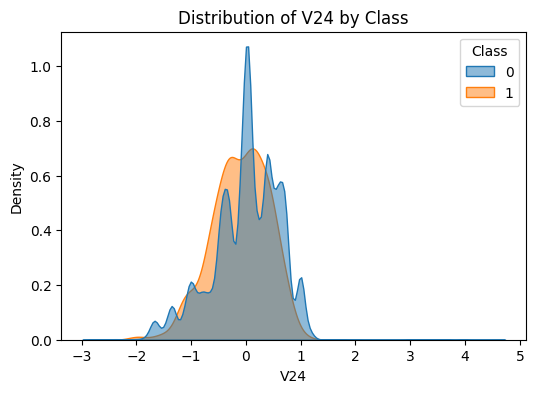

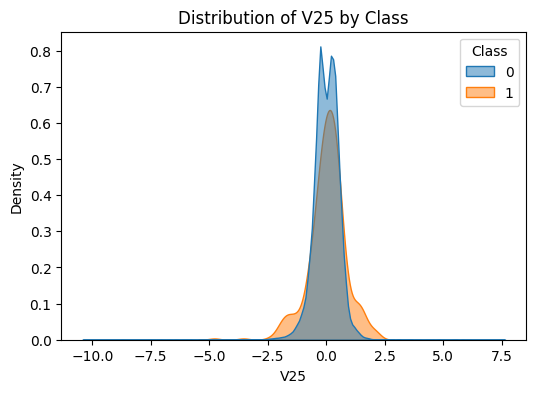

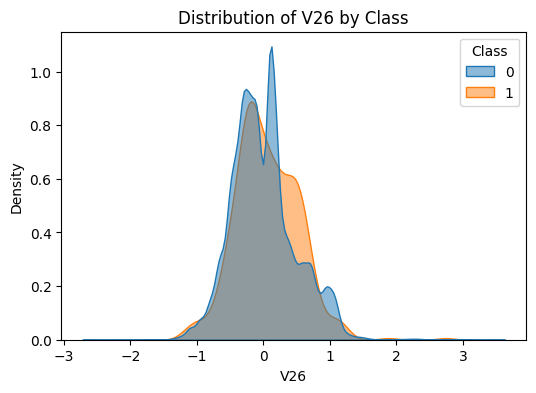

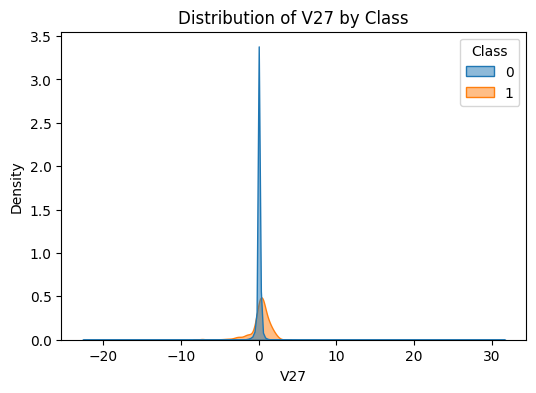

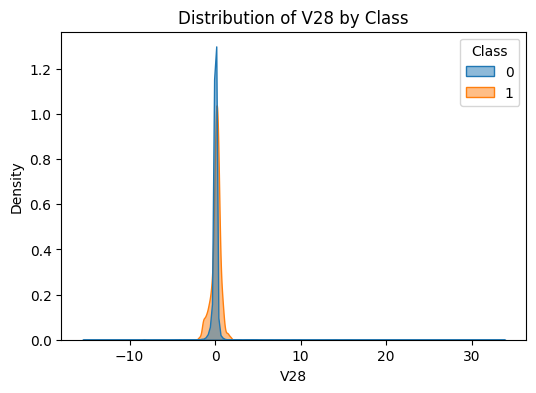

In [14]:
pca_features = [col for col in df.columns if col.startswith("V")]

# Plot distributions for each PCA component
for col in pca_features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue="Class", common_norm=False, fill=True, alpha=0.5)
    plt.title(f"Distribution of {col} by Class")
    plt.show()

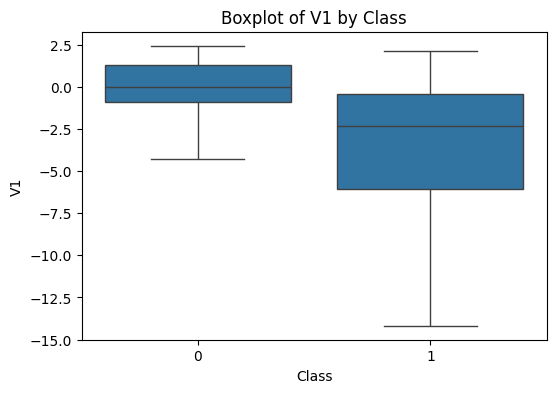

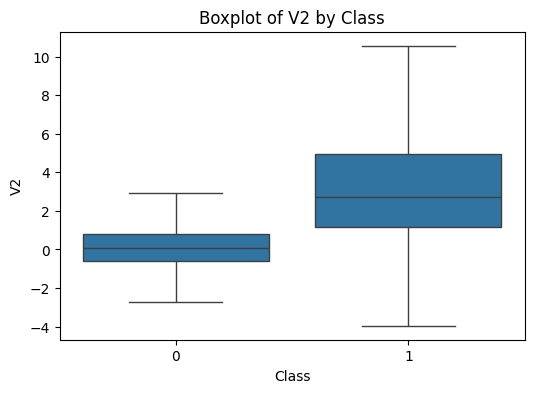

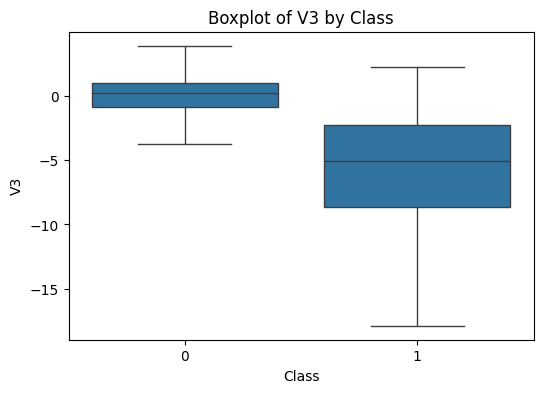

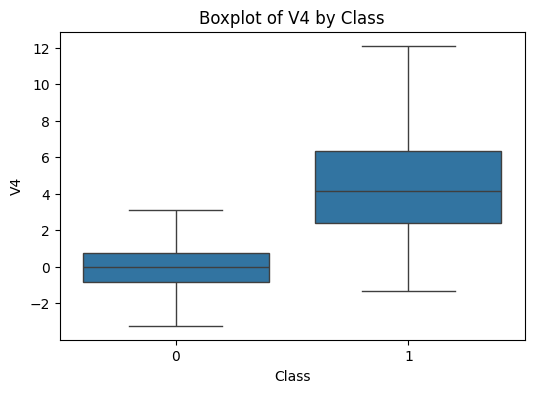

In [15]:
for col in pca_features[:4]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="Class", y=col, showfliers=False)
    plt.title(f"Boxplot of {col} by Class")
    plt.show()

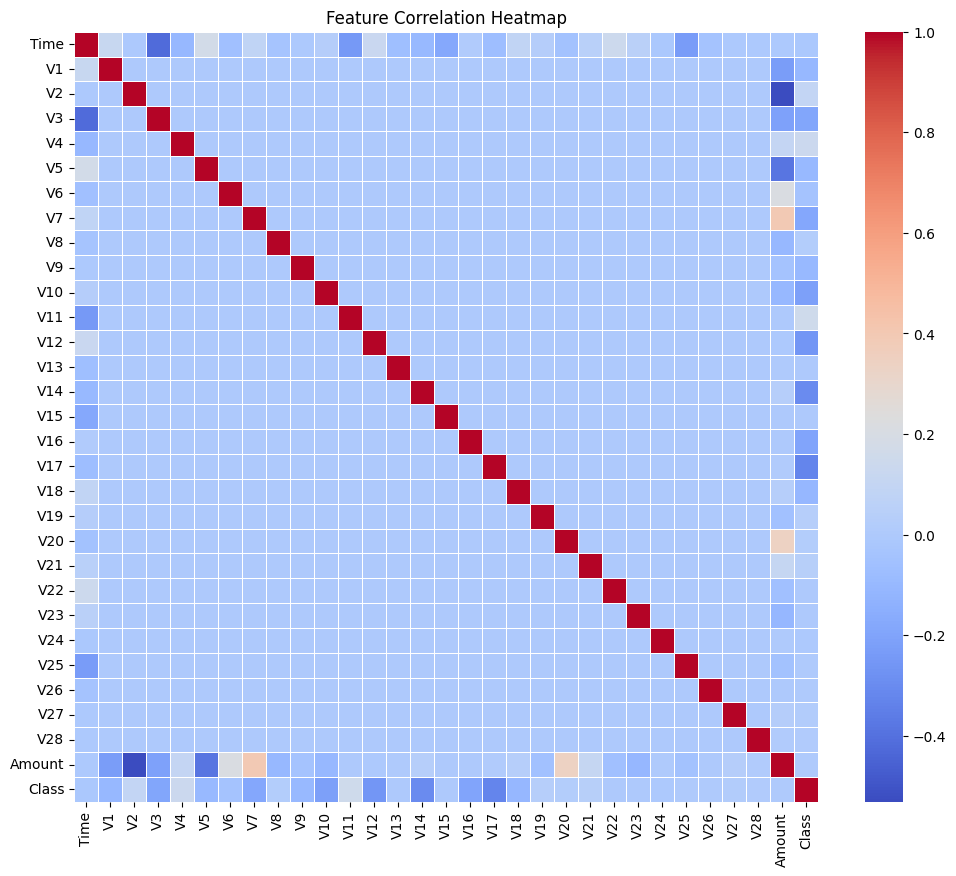

In [16]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

C:\Users\lukeh\AppData\Local\Temp\ipykernel_8988\4014358469.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=class_corr.index, x=class_corr.values, palette="viridis")


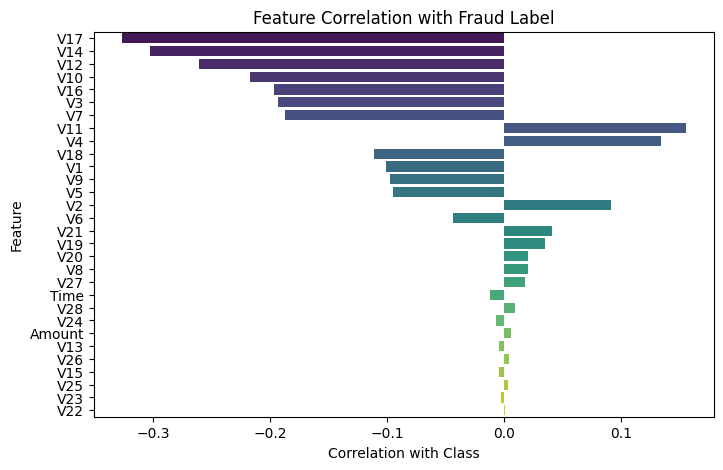

In [19]:
class_corr = df.corr()["Class"].drop("Class").sort_values(key=abs, ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(y=class_corr.index, x=class_corr.values, palette="viridis")
plt.ylabel("Feature")
plt.xlabel("Correlation with Class")
plt.title("Feature Correlation with Fraud Label")
plt.show()

## Multivariate Patterns

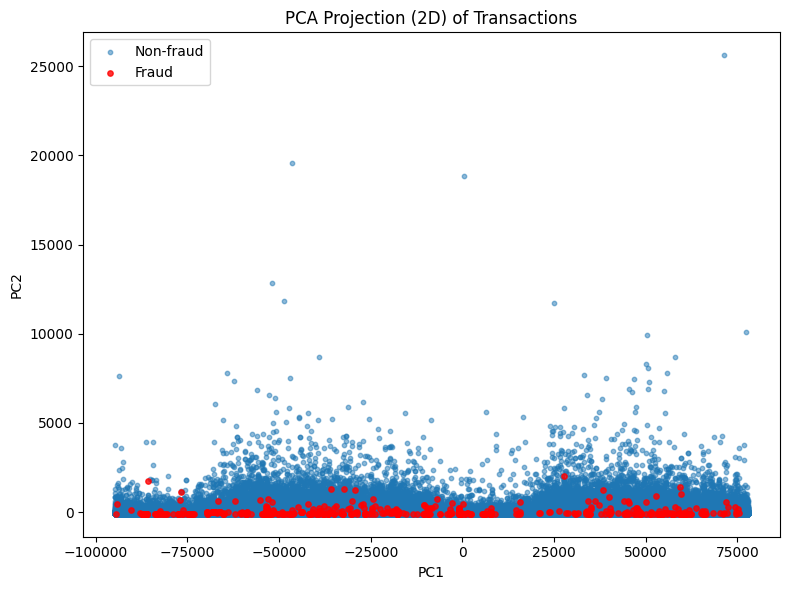

Explained variance ratio: [9.99972249e-01 2.77382192e-05]


In [ ]:
from sklearn.decomposition import PCA

# Drop the target for PCA projection
X_features = df.drop(columns=['Class'])
y_labels = df['Class']

# Run PCA to reduce to 2 dimensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_features)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_labels == 0, 0], X_pca[y_labels == 0, 1],
            label='Non-fraud', alpha=0.5, s=10)
plt.scatter(X_pca[y_labels == 1, 0], X_pca[y_labels == 1, 1],
            label='Fraud', alpha=0.8, s=15, color='red')
plt.title("PCA Projection (2D) of Transactions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 2.908s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 284.472327
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.749027
[t-SNE] KL divergence after 1000 iterations: 0.320711


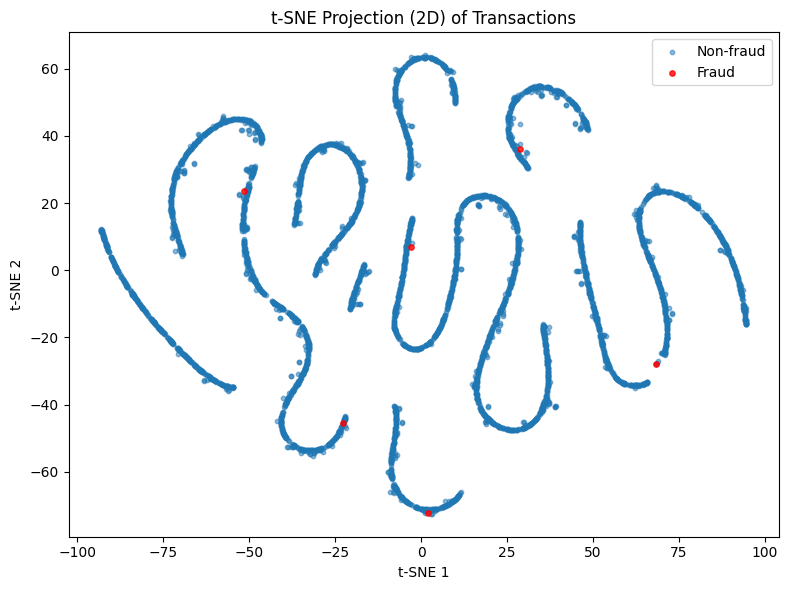

In [22]:
from sklearn.manifold import TSNE

# Due to computational cost, sample the dataset for t-SNE
sample_size = 5000
df_sample = df.sample(n=sample_size, random_state=42)
X_sample = df_sample.drop(columns=['Class'])
y_sample = df_sample['Class']

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_sample)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[y_sample == 0, 0], X_tsne[y_sample == 0, 1],
            label='Non-fraud', alpha=0.5, s=10)
plt.scatter(X_tsne[y_sample == 1, 0], X_tsne[y_sample == 1, 1],
            label='Fraud', alpha=0.8, s=15, color='red')
plt.title("t-SNE Projection (2D) of Transactions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


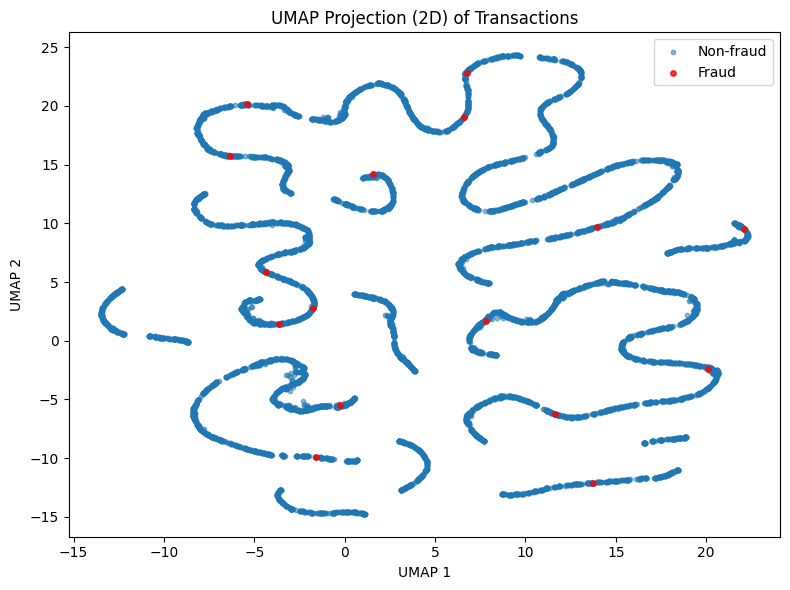

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

sample_size = 10000
df_sample = df.sample(n=sample_size, random_state=42)
X_sample = df_sample.drop(columns=['Class'])
y_sample = df_sample['Class']

# Run UMAP
umap_reducer = umap.UMAP(
    n_neighbors=15,      # controls local vs. global structure
    min_dist=0.1,        # controls how tightly points are packed
    n_components=2, 
    random_state=42
)
X_umap = umap_reducer.fit_transform(X_sample)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[y_sample == 0, 0], X_umap[y_sample == 0, 1],
            label='Non-fraud', alpha=0.5, s=10)
plt.scatter(X_umap[y_sample == 1, 0], X_umap[y_sample == 1, 1],
            label='Fraud', alpha=0.8, s=15, color='red')
plt.title("UMAP Projection (2D) of Transactions")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.show()


# Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train positive cases: {round(100*sum(y_train)/X_train.shape[0],3)}%")
print(f"Test positive cases: {round(100*sum(y_test)/X_test.shape[0],3)}%")

Train positive cases: 0.173%
Test positive cases: 0.172%


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# We want to scale Time and Amount, whilst leaving PCA columns untouched
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['Time', 'Amount'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 5: Fit model
pipeline.fit(X_train, y_train)


,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scale', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962



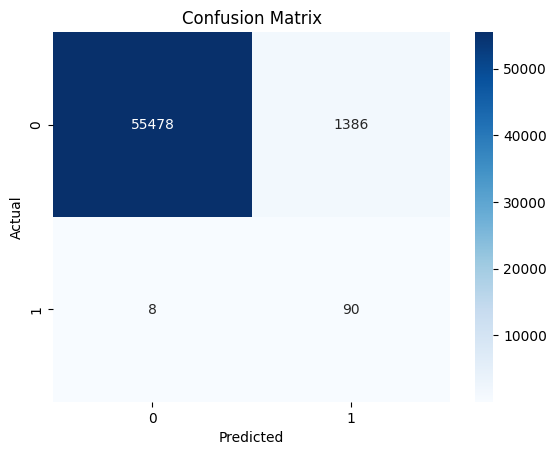

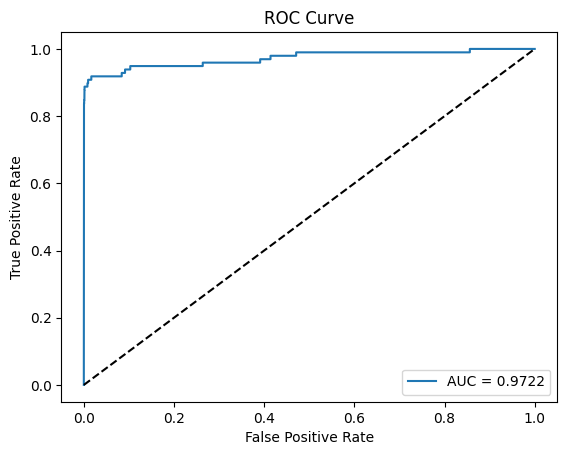

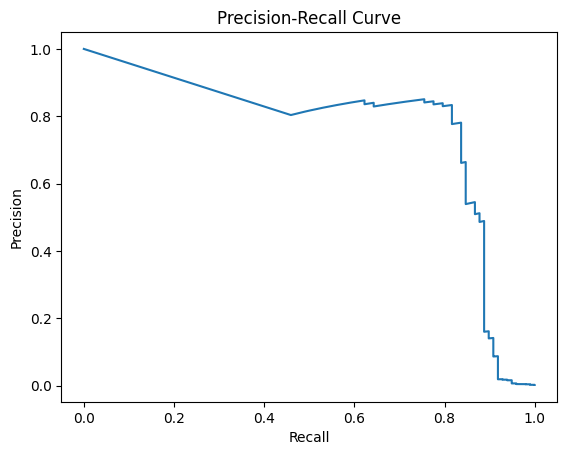

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Classification Report
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()